# Color quantization & first evaluation of color histogram classifier

## Loading the data

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from ipywidgets import interact
import ipywidgets as widgets

from toolkit import get_data_set

In [2]:
X, Y = get_data_set()
X.shape, Y.shape

((285,), (285,))

## What the data looks like ?

In [3]:
nb_class = np.max(Y)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, x in enumerate(X[Y == class_]):
        ax_arr[i].imshow(x)

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

# Color reduction

## Image mask

In [4]:
gray_threshold = 245

masks = np.array([
    img.sum(axis=-1) < (gray_threshold * 3)
    for img in X
], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    _, ax_arr = plt.subplots(nrows=1, ncols=5, figsize=(12,4))
    for i, mask in enumerate(masks[Y == class_]):
        ax_arr[i].imshow(mask, cmap='gray')

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Sampling pixels

In [44]:
nb_sample = 50000

nb_images_per_class = 5
nb_images = nb_class * nb_images_per_class
nb_sample_per_image = nb_sample // nb_images

sample_pxls = X[0][masks[0]][0] # Initialize arbitrary to be able to use np.vstack
for img, mask in zip(X[1:], masks[1:]):
    pxls = img[mask]
    new_sample_pxls_id = np.random.choice(pxls.shape[0], size=nb_sample_per_image, replace=False)
    sample_pxls = np.vstack((sample_pxls, pxls[new_sample_pxls_id]))

sample_pxls.shape, sample_pxls.dtype

((49701, 3), dtype('uint8'))

## Selecting color quantization threshold

In [6]:
from sklearn.cluster import KMeans
from tqdm import tqdm

# How to choose the right number of colors ?

inertias = []
new_colors = []
color_range = (2, 20)

# Compute new_colors and inertias
for i in tqdm(range(*color_range)):
    kmeans = KMeans(n_clusters=i, random_state=42)
    
    kmeans.fit(sample_pxls)
    inertias.append(kmeans.inertia_)
    
    new_color = kmeans.cluster_centers_.astype(np.uint8)
    new_colors.append(new_color)

100%|█████████████████████████████████████████████████████████████████████| 18/18 [00:53<00:00,  2.96s/it]


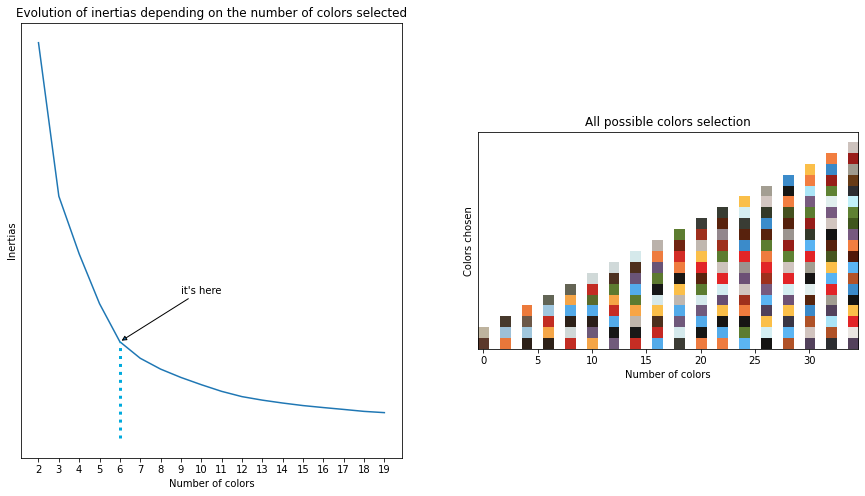

In [64]:
nb_opti_color = 6
_, ax_arr = plt.subplots(ncols=2, figsize=(15,8))
    
# Plot new_colors
nb_tested_colors = color_range[1] - color_range[0]
new_color_img = np.full(shape=(color_range[1], 2 * nb_tested_colors - 1, 3), fill_value=255)

for i, new_color in enumerate(new_colors):
    new_color_img[:new_color.shape[0], i * 2] = new_color[np.newaxis, ...]

ax_arr[1].imshow(new_color_img, origin='lower')
ax_arr[1].set_title("All possible colors selection")
ax_arr[1].set_xlabel("Number of colors")
ax_arr[1].set_ylabel("Colors chosen")
ax_arr[1].set_yticklabels([]); ax_arr[1].set_yticks([])

# Plot inertias
ax_arr[0].plot(range(*color_range), inertias)
ax_arr[0].set_title("Evolution of inertias depending on the number of colors selected")
ax_arr[0].set_xlabel("Number of colors")
ax_arr[0].set_ylabel("Inertias")
ax_arr[0].set_yticklabels([]); ax_arr[0].set_yticks([])
ax_arr[0].set_xticks(range(color_range[-1]))
ax_arr[0].plot([nb_opti_color, nb_opti_color],[0, inertias[nb_opti_color - color_range[0]]],':', color = '#00aadd', lw=3)
ax_arr[0].annotate(r"it's here", xy=(nb_opti_color, inertias[nb_opti_color - color_range[0]]),
                   xytext=(nb_opti_color * 1.5, inertias[nb_opti_color - color_range[0]] * 1.5), arrowprops=dict(arrowstyle="-|>"));

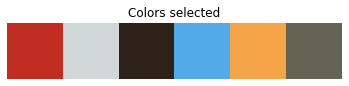

In [8]:
# Example of color sampling
nb_color = nb_opti_color

kmeans = KMeans(n_clusters=nb_color, random_state=42)
kmeans.fit(sample_pxls)
new_color_lut = kmeans.cluster_centers_.astype(np.uint8)

plt.imshow(new_color_lut[np.newaxis, :, :]); plt.axis("off"); plt.title("Colors selected");

In [59]:
color_maps = np.array([
    kmeans.predict(img[mask])
    for img, mask in zip(X, masks)
], dtype=object)
color_maps[0]

def get_recolored_img(img: np.array, mask: np.array, color_map: np.array) -> np.array:
    recolored_img = np.full_like(img, 255)
    recolored_img[mask] = new_color_lut[color_map]
    
    return recolored_img

recolored_X = np.array([
    get_recolored_img(img, mask, color_map)
    for img, mask, color_map in zip(X, masks, color_maps)
], dtype=object)

@interact(class_=widgets.BoundedIntText(min=1, max=nb_class))
def print_class(class_: int) -> None:
    fig = plt.figure(constrained_layout=True, figsize=(12,4))
    subfigs = fig.subfigures(nrows=2, ncols=1)
    ax_recolored = subfigs[0].subplots(nrows=1, ncols=nb_images_per_class); subfigs[0].suptitle("Recolored", fontsize=16)
    ax_original  = subfigs[1].subplots(nrows=1, ncols=nb_images_per_class); subfigs[1].suptitle("Original", fontsize=16)
    
    for i, (recolored_x, x) in enumerate(zip(recolored_X[Y == class_], X[Y == class_])):
        ax_recolored[i].imshow(recolored_x)
        ax_original[i].imshow(x)
        ax_recolored[i].axis("off"); ax_original[i].axis("off")

interactive(children=(BoundedIntText(value=1, description='class_', max=57, min=1), Output()), _dom_classes=('…

## Compute the color histograms

In [60]:
def get_hist(color_map: np.array) -> np.array:
    hist = np.bincount(color_map, minlength=nb_color)
    norm_hist = hist / color_map.shape[0]
    
    return norm_hist

color_histograms = np.array([get_hist(color_map) for color_map in color_maps], dtype=object)
color_histograms[0]

array([0.23272214386459802, 0.04724964739069112, 0.3117947813822285, 0.0,
       0.34837799717912554, 0.05985543018335684], dtype=object)

In [61]:
colors_for_bars = new_color_lut / 255  # matplotlib colors are RGB values scaled to [0,1]

@interact(x_index=widgets.BoundedIntText(max=X.shape[0]))
def show_histograms(x_index: int) -> None:
    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1)
    plt.imshow(X[x_index])
    plt.axis('off'); plt.title("Original")
    plt.subplot(1,3,2)
    plt.imshow(recolored_X[x_index])
    plt.axis('off'); plt.title("Recolored")
    plt.subplot(1,3,3, aspect=len(color_histograms[0]))
    plt.ylim(0, 1)
    plt.bar(range(len(color_histograms[x_index])), 
            color_histograms[x_index] / color_histograms[x_index].max(), 
            color=colors_for_bars)
    plt.xticks([]); plt.title("Histogram")
    plt.show()

interactive(children=(BoundedIntText(value=0, description='x_index', max=285), Output()), _dom_classes=('widge…

## Compute the distance matrix
Because color histograms are **very compact**, it is **very fast** to compute the distance matrix (even if the complexity is $O(n^2)$).

In [12]:
from scipy.spatial.distance import cosine

dist_mat = np.ones((len(X), len(X))) # distances will be between 0 (closest) and 1 (farthest)
for i in range(len(X)):
    for j in range(len(X)):
        dist_mat[i,j] = cosine(color_histograms[i], color_histograms[j])

Correct the diagonal to avoid getting the same result over and over: we set the distance of one element against itself to the maximum distance.

In [13]:
dist_mat[np.diag_indices_from(dist_mat)] = 1

In [14]:
idx_of_best_matches_per_row = np.argsort(dist_mat, axis=1)

## Find the best matches for each image

In [15]:
nb_images_displayed = 5

@interact(x_index=widgets.BoundedIntText(max=X.shape[0] - 1))
def show_similar_images(x_index: int) -> None:
    plt.figure(figsize=(12,8))
    nb_columns = nb_images_displayed + 1
    
    plt.subplot(1, nb_columns, 1)
    plt.imshow(recolored_X[x_index])
    plt.axis("off")
    plt.title("Original")
    
    for image_id in range(nb_images_displayed):
        idx = idx_of_best_matches_per_row[x_index, image_id]
        plt.subplot(1, nb_columns, image_id + 2)
        plt.imshow(recolored_X[idx])
        plt.axis("off")
        plt.title(f"({dist_mat[x_index, idx]: .6f})")

interactive(children=(BoundedIntText(value=0, description='x_index', max=284), Output()), _dom_classes=('widge…

A priori le nb de trous n'est pas ideal en second discriminateur. Contre-example:
- 0
- Peut-etre le 10 (jsp si 2 ou 3 trous)

Idees d'amelioration:
- Tester d'autres distances
- Reduire la "Color quantization" (a.k.a augmenter le nbr de couleurs) pour avoir une distance d'histogramme plus perinente
- Discrimineur de formes
- Tester
    - Soit d'augmenter le nombre de couleurs pour avoir un histogram + precis
    - Soit de tester des discriminateurs de formes

# Classifier base on image color histogram

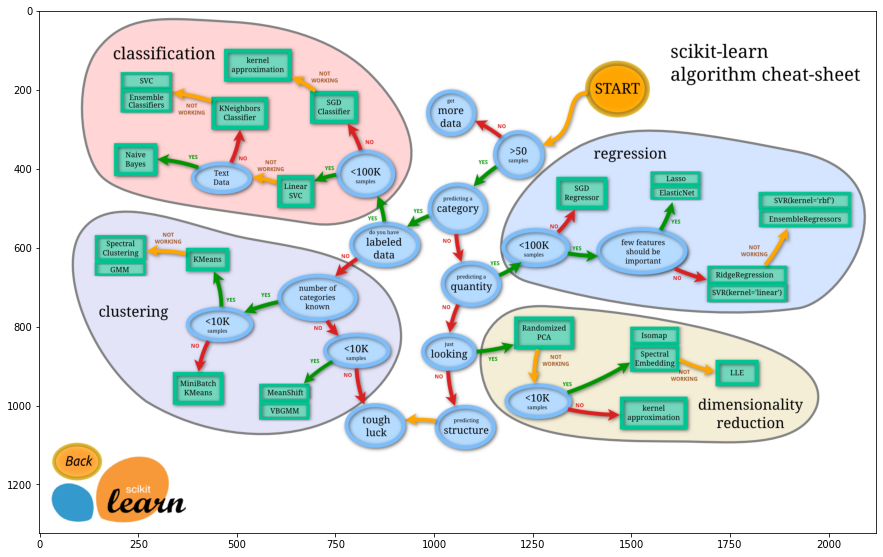

In [74]:
from PIL import Image
import urllib
from matplotlib import pyplot as plt

img = np.array(Image.open(urllib.request.urlopen("https://scikit-learn.org/stable/_static/ml_map.png")))
plt.imshow(img);

In [76]:
from sklearn.model_selection import cross_validate
from sklearn.svm import LinearSVC

linear_svc = LinearSVC()
cross_validate(linear_svc, color_histograms, Y, cv=5)["test_score"]

array([0.29824561, 0.28070175, 0.29824561, 0.26315789, 0.29824561])

In [84]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn_models = cross_validate(knn, color_histograms, Y, cv=5, return_estimator=True)
best_knn = knn_models["estimator"][np.argmax(knn_models["test_score"])]
knn_models["test_score"]

array([0.80701754, 0.89473684, 0.85964912, 0.8245614 , 0.85964912])

In [86]:
from sklearn.svm import SVC

svc = SVC()
svc_models = cross_validate(svc, color_histograms, Y, cv=5, return_estimator=True)
best_svc = svc_models["estimator"][np.argmax(svc_models["test_score"])]
svc_models["test_score"]

array([0.75438596, 0.84210526, 0.80701754, 0.89473684, 0.84210526])

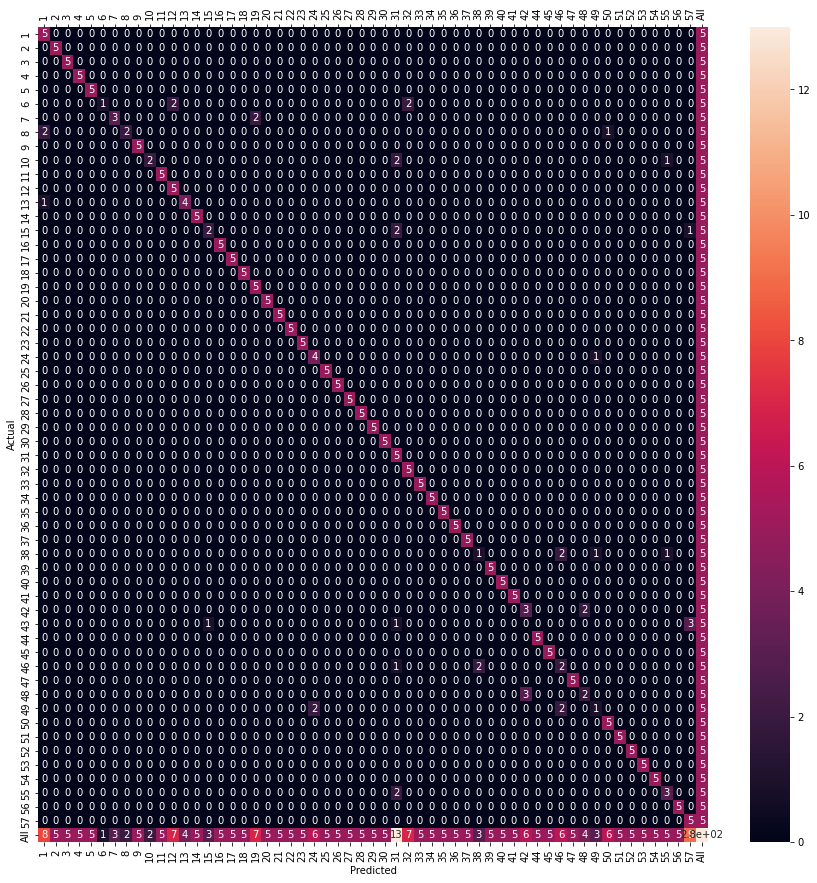

In [87]:
import pandas as pd
import seaborn as sn

def print_confusion_matrix(predicted: np.array, actual: np.array) -> None:
    confusion_matrix = pd.crosstab(actual, predicted, rownames=['Actual'], colnames=['Predicted'], margins=True)
    plt.tick_params(axis='both', which='major', labelsize=10, labelbottom=True, bottom=True, top=True, labeltop=True)
    sn.heatmap(confusion_matrix, annot=True, vmax=np.max(confusion_matrix.max()[:-1]))
    plt.show()
    
plt.rcParams["figure.figsize"] = (15,15)
print_confusion_matrix(best_svc.predict(color_histograms), Y)

On voit la class 6 (Le bon homme de neige) est confondu avec les class 12 et 32, respectivement le Fantome et le Crayon.
Ce qui est logique comme ils ont tous les 3 des couleurs tres similaires.

Peut-on ameliorer les resultats du classifier en changeant la color quanitzation ?